# Prism data processing

### Setup

#### Ensuring Reproducibility with Seeds




In [1]:
seed_value=42
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)


In [2]:
import pandas as pd

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from tqdm.auto import trange

from scipy.signal import find_peaks

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression, f_regression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization, Input, Activation, Concatenate
from tensorflow.keras import layers, optimizers, callbacks, Model
from keras.initializers import zeros
import keras_tuner as kt
from keras import backend as K

In [3]:
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import propagators
from pyGDM2 import core
from pyGDM2 import visu
from pyGDM2 import tools
from pyGDM2 import linear

In [4]:
plt.rcParams.update({
   "font.family": "serif",  # use serif/main font for text elements
   "text.usetex": True,     # use inline math for ticks
   "pgf.rcfonts": False     # don't setup fonts from rc parameters
   })

### Read and display data

In [26]:
df1=pd.read_csv(r'prism_dataset.csv')
df1

,length,height,edge,ni,thetax,thetay,thetaz,Ext. maxima,wavelgth ext. max.,Sca. maxima,wavelgth sca. max.,Abs. maxima,wavelgth abs. max.,EF. maxima,wavelgth ef. max.
0,137.0,14.7,0.81,1.84,27.0,6.0,15.0,35496.257023,838.0,12917.745126,838.0,22578.511897,838.0,1.286153,862.0
1,134.0,16.2,0.89,1.94,48.0,39.0,33.0,12977.941537,868.0,4275.411517,865.0,8730.240013,868.0,1.104350,907.0
2,156.0,19.3,0.82,1.33,27.0,90.0,27.0,1752.227703,508.0,114.708661,523.0,1648.593840,505.0,1.028197,559.0
3,131.0,18.0,0.81,1.64,66.0,69.0,3.0,25879.449014,736.0,8787.740190,730.0,17142.814271,736.0,1.168914,766.0
4,138.0,10.0,0.33,1.38,27.0,36.0,12.0,22717.188788,808.0,4969.636688,808.0,17751.289608,805.0,1.175315,808.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,112.0,9.8,0.72,1.90,51.0,39.0,57.0,8040.319155,862.0,2841.506976,859.0,5207.675465,862.0,1.066583,892.0
1020,64.0,16.0,0.37,1.27,18.0,81.0,54.0,3454.676109,610.0,316.395760,613.0,3145.961656,607.0,1.035611,619.0
1021,142.0,15.1,0.23,1.98,57.0,54.0,87.0,4836.022147,775.0,1277.052391,772.0,3590.933190,775.0,1.022872,424.0
1022,138.0,20.0,0.74,1.99,72.0,48.0,78.0,4695.058647,511.0,1226.458577,880.0,4109.071210,511.0,1.039708,466.0


### Defining the different sets

In [7]:
X=df[['length','height','edge','ni','thetax','thetay','thetaz']]
Y=df[['wavelgth ext. max.']]
X_train, X_test,Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# Multilayer perceptron for regression

Parametring the model

In [6]:
def build_modelMLP3(hp):
    """
    This function builds a Sequential multi-layer perceptron (MLP) model with a variable number of hidden dense layers.
    The number of hidden layers, number of neurons in each hidden layer, and the learning rate for the model's optimizer are determined by a hyperparameter search space.

    Arguments:
    hp -- Keras Tuner hyperparameters class instance, used for defining the learning rate range, the number of neurons, and the number of hidden layers

    Returns:
    The constructed Sequential MLP model with defined optimizer, loss function, learning rate, neuron count, and hidden layer count.
    """
    n_hidden = hp.Int("n_hidden", min_value=2, max_value=4)
    n_neurons = hp.Int("n_neurons", min_value=1, max_value=400)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-1,sampling="log")


    model=Sequential() 
    model.add(Normalization(input_shape=[7]))
    for _ in range(n_hidden):
        model.add(Dense(units=n_neurons,activation='swish',kernel_initializer="he_normal"))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizers.Adam(learning_rate), loss='mean_squared_error',metrics=["accuracy"])
    return model

In [9]:
objective = kt.Objective("val_accuracy", direction="max")
#Use a bayesian tuner to find the best hyperparameters
bayesian_tuner = kt.BayesianOptimization(
    build_modelMLP3,
    objective=objective,
    max_trials=10,
    overwrite=True,
    directory="hpMLP3",
    project_name="my_bayesian_search",
)
#lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
bayesian_tuner.search(X_train, Y_train, epochs=1000,batch_size=4,validation_split=0.2,verbose=False)
bayesian_tuner.get_best_hyperparameters()[0].values

INFO:tensorflow:Oracle triggered exit


{'n_hidden': 3, 'n_neurons': 119, 'learning_rate': 0.09612513400908385}

### Building and Training the Model


In [8]:
# Build the model with the optimal hyperparameters and train it on the data
modelMLP2=Sequential() 
modelMLP2.add(Normalization(input_shape=[7]))
for _ in range(2):
        modelMLP2.add(Dense(units=20,activation='swish',kernel_initializer="he_normal"))
modelMLP2.add(Dense(units=1))
modelMLP2.compile(optimizer=optimizers.Adam(learning_rate=1e-2), loss='mean_squared_error')

#train
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=500)
early_stopping_cb = callbacks.EarlyStopping(monitor='val_loss',patience=2000,restore_best_weights=True)
history=modelMLP2.fit(X_train, Y_train, epochs=10000,validation_split=0.2,verbose=False,callbacks=[early_stopping_cb,lr_scheduler],batch_size=1)

#evaluate the model

early_stopping_cb.stopped_epoch


2023-06-29 18:57:54.417994: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 109ms/step


(6167,
 6291.33154296875,
 array([[690.04156],
        [738.5098 ]], dtype=float32),
      wavelgth ext. max.
 525               685.0
 357               790.0)

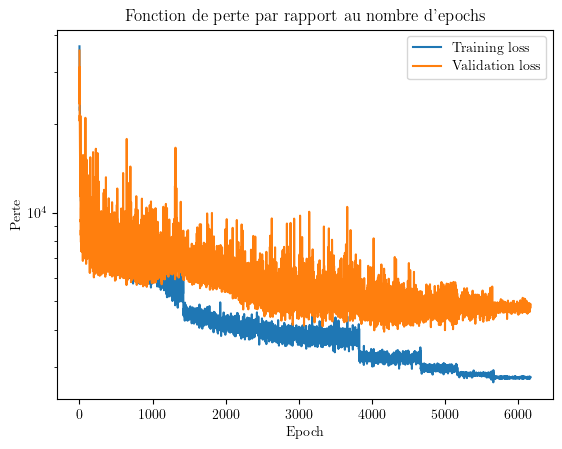

7/7 [==============================] - 0s 612us/step
RMSE : 79.3179143886723 nm MAE : 47.186380823647106 nm


In [22]:
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('Fonction de perte par rapport au nombre d\'epochs')
plt.ylabel('Perte')
plt.xlabel('Epoch')
plt.legend(['Training loss','Validation loss'])
plt.show()

mse_test=modelMLP2.evaluate(X_test, Y_test)
rmse=np.sqrt(mse_test)
mae=mean_absolute_error(Y_test,modelMLP2.predict(X_test))
print('RMSE :',rmse,'nm','MAE :',mae,'nm')


### Learning process through epochs (performance scheduling) 

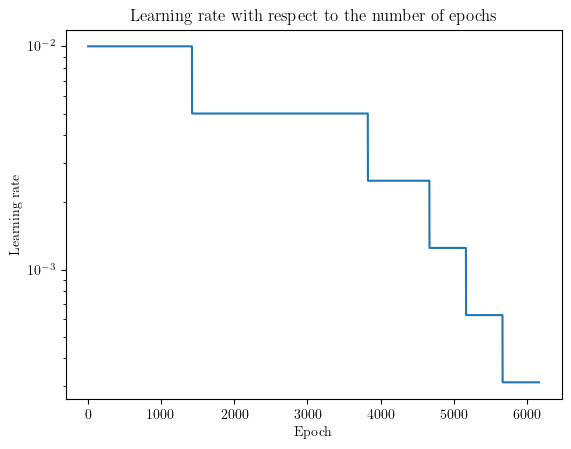

In [23]:
plt.semilogy(history.history["lr"])
plt.title('Learning rate with respect to the number of epochs')
plt.ylabel('Learning rate')
plt.xlabel('Epoch')
plt.show()

# Test against a randomly chosen plasmon band

The mean absolute error is not deemed particularly relevant for assessing the performance of the model in this context. A different metric is needed for comparison. For this purpose, the mean absolute error could be calculated as if the predicted $\lambda_{LSPR}$ value were randomly chosen from within the studied range of wavelengths.

It appears that the model's performance is approximately twice as good as a random selection of a $\lambda_{LSPR}$ value.

In [25]:
err_rand=[]

for i in np.linspace(600, 850, 51):
    rand_wl=np.random.randint(600,850)
    err_rand.append(np.abs(rand_wl-i))
mae_rand=np.mean(err_rand)
print('random MAE',mae_rand)

random MAE 84.29411764705883
